# Reproduction of grokking on modular addition problem

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [1]:
# Imports
import os
import datetime
import random
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

local_host = True if 'oveggeland' in list(notebookapp.list_running_servers())[0]['notebook_dir'] else False

# Step 1: Create dataset

In [2]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_frac=0.3, number_occurence=100):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """
    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, int(train_frac*number_occurence)))
    val_idx = np.zeros((10, number_occurence - int(train_frac*number_occurence)))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, number_occurence)
        
        train_idx[number], val_idx[number] = train_test_split(random_selection, train_size=train_frac, random_state=seed)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx.flatten().astype(int)][:, None, :, :].float()
    Y_train = dataset.targets[train_idx.flatten().astype(int)]
    X_val = dataset.data[val_idx.flatten().astype(int)][:, None, :, :].float()
    Y_val = dataset.targets[val_idx.flatten().astype(int)]
    return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = get_datasets()
print(X_train.shape)
print(X_val.shape)

torch.Size([300, 1, 28, 28])
torch.Size([700, 1, 28, 28])


# Step 2: Define model
Using the same architecture as in lab work for IMT 4392

In [3]:
# Default network architecture
img_size = 28

# Conv layer 1
filter_size1 = 5
num_filter1  =16
pool_size1 = 2

# Conv layer 2
filter_size2 = 5
num_filter2 =36
pool_size2 = 2

# Fully connected layer
lin_input_size = int(num_filter2*(img_size/(pool_size1*pool_size2))**2)
num_neuron =  128
num_classes = 10


class NumberDetector(nn.Module):
    def __init__(self):
        super(NumberDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter1, kernel_size=filter_size1,padding=filter_size1//2)
        self.conv2 = nn.Conv2d(num_filter1, num_filter2, kernel_size=filter_size2,padding=filter_size2//2)
        self.relu  = nn.ReLU()
        self.fc1 = nn.Linear(lin_input_size, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_classes)

    def forward(self, x):
        # Conv layer 1
        x=self.conv1(x)
        x= F.max_pool2d(x,pool_size1)
        x=self.relu(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = F.max_pool2d(x,pool_size2)
        
        # Fulle connected layer
        x = x.view(-1, lin_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training the model

In [4]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    if save_models:
        os.mkdir(save_root/run_name)
        save_dict = {'model':model.state_dict()}
        torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_frac=train_frac, number_occurence=number_occurence)
        
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []

    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_pred = model(X_train)
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses.append(train_loss.item())

        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses.append(val_loss.item())

        # Print status
        if epoch%1 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

        # Calc gradients and perform backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if val_loss.item() < stopping_thresh:
            break

        if (save_models) and (epoch%save_every == 0):
            if val_loss.item() < stopping_thresh:
                break
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    if not save_models:
        os.mkdir(save_root/run_name)
    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [5]:
# Model params
lr=1e-3
weight_decay = 1.0

# Training params
num_epochs = 100
save_models = True
save_every = 10
save_root = Path("phd/IMT4392/project/numbers/checkpoints") if not local_host else Path("checkpoints")
stopping_thresh = -1

# Dataset params
train_frac = 0.2
number_occurence = 10

# Run training
exp_name = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
train(exp_name)

0_2.2044_2.2464
Saved model to checkpoints/2022_10_31__16_58_53/0.pth
1_2.2044_2.2464
2_1.5836_1.7256
3_1.7042_1.8972
4_1.6610_1.9630
5_1.2159_1.7730
6_0.7522_1.6911
7_-0.0275_1.4637
8_-1.4598_1.2706
9_-2.6326_0.9520
10_-2.7292_1.1405
Saved model to checkpoints/2022_10_31__16_58_53/10.pth
11_-1.1687_1.4413
12_-2.9215_1.4412
13_-3.8841_1.4360
14_-3.5536_1.4506
15_-3.8659_1.4461
16_-4.3867_1.4249
17_-5.0133_1.3916
18_-5.8215_1.3445
19_-6.4643_1.3110
20_-6.6968_1.3000
Saved model to checkpoints/2022_10_31__16_58_53/20.pth
21_-6.6816_1.2886
22_-6.8003_1.2696
23_-6.7236_1.2589
24_-7.4143_1.2199
25_-7.7787_1.1975
26_-8.1360_1.1871
27_-8.4078_1.1868
28_-8.5574_1.1905
29_-8.5782_1.1977
30_-8.5284_1.2027
Saved model to checkpoints/2022_10_31__16_58_53/30.pth
31_-8.4242_1.2084
32_-8.3281_1.2081
33_-8.2571_1.2083
34_-8.2611_1.2071
35_-8.3490_1.2049
36_-8.5113_1.2016
37_-8.7232_1.1973
38_-8.9674_1.1924
39_-9.2205_1.1873
40_-9.4632_1.1820
Saved model to checkpoints/2022_10_31__16_58_53/40.pth
41_-9

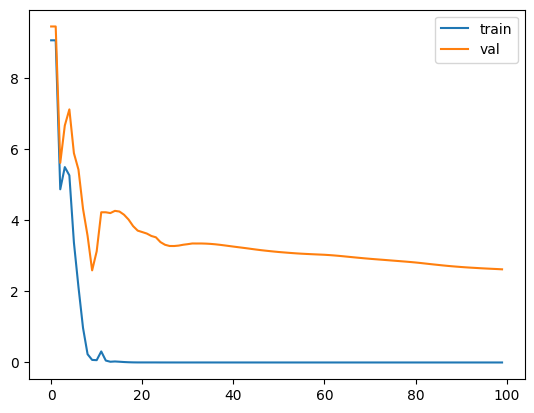

In [6]:
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
plt.plot(load_dict['train_losses'], label='train')
plt.plot(load_dict['val_losses'], label="val")

plt.legend()
plt.show()